In [1]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch

import functions_IMU
import functions_generell
import functions_PRESSURE

DATEN EINLESEN FÜR ALLE TEILNEHMER

In [2]:
#%% Daten einlesen für alle Teilnehmer-------------------------------------------------------------------------------------------
# liste der Teilneher
participants = ['ID_1_Dabisch_Samuel', 'ID_2_Pohl_Jannis', 'ID_3_Kleber_Christian',
                'ID_4_Schröter_Till', 'ID_5_Zaschke_Lenard', 'ID_6_Petroll_Finn', 'ID_7_Gruber_Julius']

# Alle Daten der Teilnehmer einlesen und verarbeiten
all_data = {}

for participant in participants:
    folder_path = os.path.join('data_final', participant)
    
    # Lade die 6 CSV-Dateien für den Teilnehmer
    real_1, real_2, vr_1, vr_2, mvc_beine, mvc_hals = functions_generell.load_csvs(folder_path)
    
    # Speichere die DataFrames im Dictionary
    all_data[participant] = {
        'REAL_1': real_1,
        'REAL_2': real_2,
        'VR_1': vr_1,
        'VR_2': vr_2,
        'MVC_Beine': mvc_beine,
        'MVC_Hals': mvc_hals
    }
    
    print(f"Daten für {participant} geladen")

print(f"\nAlle Daten geladen! {len(all_data)} Teilnehmer erfolgreich eingelesen.")

Daten für ID_1_Dabisch_Samuel geladen
Daten für ID_2_Pohl_Jannis geladen
Daten für ID_3_Kleber_Christian geladen
Daten für ID_4_Schröter_Till geladen
Daten für ID_5_Zaschke_Lenard geladen
Daten für ID_6_Petroll_Finn geladen
Daten für ID_7_Gruber_Julius geladen

Alle Daten geladen! 7 Teilnehmer erfolgreich eingelesen.


EMG FILTER (30-500 HZ) + 50ms RMS

In [3]:
def _infer_fs_from_time(t: np.ndarray) -> float:
    t = np.asarray(t, dtype=float)
    dt = np.diff(t)
    dt = dt[np.isfinite(dt) & (dt > 0)]
    if dt.size == 0:
        raise ValueError("Kann fs nicht aus time ableiten (time hat keine positiven Abstände).")
    return 1.0 / np.median(dt)

def _bandpass_filter(x: np.ndarray, fs: float, low: float = 30.0, high: float = 500.0, order: int = 4) -> np.ndarray:
    nyq = fs / 2.0
    high = min(high, nyq * 0.999)  # falls fs klein ist
    if low >= high:
        raise ValueError(f"Ungültige Bandpass-Grenzen: low={low}, high={high}, nyq={nyq}")
    b, a = butter(order, [low / nyq, high / nyq], btype="bandpass")
    x = np.asarray(x, dtype=float)
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    return filtfilt(b, a, x)

def _moving_rms(x: np.ndarray, fs: float, window_ms: float = 50.0) -> np.ndarray:
    win = int(round((window_ms / 1000.0) * fs))
    win = max(win, 1)
    x2 = np.asarray(x, dtype=float) ** 2
    kernel = np.ones(win, dtype=float) / win
    mean_sq = np.convolve(x2, kernel, mode="same")
    return np.sqrt(mean_sq)

def get_emg_cols(df: pd.DataFrame):
    # EMG-Spalten erkennen (typisch: "(uV)" im Namen)
    return [c for c in df.columns if re.search(r"\(uV\)", str(c))]

def filter_emg_in_df(df: pd.DataFrame, time_col: str = "time", emg_cols=None,
                     low=30.0, high=500.0, rms_ms=50.0, bp_order=4,
                     suffix_filt="_bp", suffix_rms="_rms50"):
    if emg_cols is None:
        emg_cols = get_emg_cols(df)
    if len(emg_cols) == 0:
        return df  # nichts zu tun
    
    fs = _infer_fs_from_time(df[time_col].to_numpy())
    
    for col in emg_cols:
        x = df[col].to_numpy()
        x_bp = _bandpass_filter(x, fs, low=low, high=high, order=bp_order)
        x_rms = _moving_rms(x_bp, fs, window_ms=rms_ms)
        df[col + suffix_filt] = x_bp
        df[col + suffix_rms] = x_rms
    
    return df

# Auf ALLE Datensätze anwenden (REAL/VR + MVC)
trials_to_filter = ["REAL_1", "REAL_2", "VR_1", "VR_2", "MVC_Beine", "MVC_Hals"]

for participant, pdata in all_data.items():
    for trial in trials_to_filter:
        if trial in pdata and pdata[trial] is not None:
            all_data[participant][trial] = filter_emg_in_df(all_data[participant][trial])
    print(f"EMG gefiltert + RMS für {participant}")

EMG gefiltert + RMS für ID_1_Dabisch_Samuel
EMG gefiltert + RMS für ID_2_Pohl_Jannis
EMG gefiltert + RMS für ID_3_Kleber_Christian
EMG gefiltert + RMS für ID_4_Schröter_Till
EMG gefiltert + RMS für ID_5_Zaschke_Lenard
EMG gefiltert + RMS für ID_6_Petroll_Finn
EMG gefiltert + RMS für ID_7_Gruber_Julius


MVC PEAKS BERECHNEN + TRIALS AUF %MVC NORMALISIEREN

In [4]:
# Welche Muskeln zu Beine/Hals gehören (genau wie in deinen CSV-Spaltennamen)
LEG_MUSCLES  = ["RT BICEPS FEM. (uV)", "RT MED. GASTRO (uV)", "RT VLO (uV)", "RT TIB.ANT. (uV)"]
NECK_MUSCLES = ["RT SCM (uV)", "RT CERVICAL PS (uV)"]

RMS_SUFFIX = "_rms50"  # von deinem Filtercode

def get_mvc_peak(df_mvc: pd.DataFrame, muscle_col_raw: str, rms_suffix="_rms50"):
    """
    Peak aus MVC Datensatz holen (Peak vom RMS Signal).
    """
    col = muscle_col_raw + rms_suffix
    if col not in df_mvc.columns:
        raise KeyError(f"{col} nicht im MVC-DataFrame gefunden.")
    return float(np.nanmax(df_mvc[col].to_numpy()))

def normalize_trial_to_mvc(df_trial: pd.DataFrame, mvc_peaks: dict, rms_suffix="_rms50", out_suffix="_pctMVC"):
    """
    Erstellt neue Spalten: <Muskel>_rms50_pctMVC
    """
    for muscle_raw, peak in mvc_peaks.items():
        rms_col = muscle_raw + rms_suffix
        out_col = muscle_raw + rms_suffix + out_suffix

        if rms_col not in df_trial.columns:
            continue

        if peak is None or peak <= 0 or np.isnan(peak):
            df_trial[out_col] = np.nan
        else:
            df_trial[out_col] = df_trial[rms_col] / peak * 100.0  # %MVC

    return df_trial

# Speichert MVC Peaks pro Proband
mvc_peaks_all = {}

# Trials die normalisiert werden sollen
TRIALS_TO_NORMALIZE = ["REAL_1", "REAL_2", "VR_1", "VR_2"]

for participant in participants:
    df_mvc_leg  = all_data[participant]["MVC_Beine"]
    df_mvc_neck = all_data[participant]["MVC_Hals"]

    mvc_peaks = {}

    # Bein Peaks aus MVC_Beine
    for m in LEG_MUSCLES:
        if m in df_mvc_leg.columns:
            mvc_peaks[m] = get_mvc_peak(df_mvc_leg, m, rms_suffix=RMS_SUFFIX)
        else:
            mvc_peaks[m] = None

    # Hals Peaks aus MVC_Hals
    for m in NECK_MUSCLES:
        if m in df_mvc_neck.columns:
            mvc_peaks[m] = get_mvc_peak(df_mvc_neck, m, rms_suffix=RMS_SUFFIX)
        else:
            mvc_peaks[m] = None

    mvc_peaks_all[participant] = mvc_peaks

    # Normalisieren aller REAL/VR Trials
    for trial in TRIALS_TO_NORMALIZE:
        df_trial = all_data[participant][trial]
        all_data[participant][trial] = normalize_trial_to_mvc(
            df_trial, mvc_peaks, rms_suffix=RMS_SUFFIX, out_suffix="_pctMVC"
        )

    print(f"%MVC normalisiert für {participant}")

%MVC normalisiert für ID_1_Dabisch_Samuel
%MVC normalisiert für ID_2_Pohl_Jannis
%MVC normalisiert für ID_3_Kleber_Christian
%MVC normalisiert für ID_4_Schröter_Till
%MVC normalisiert für ID_5_Zaschke_Lenard
%MVC normalisiert für ID_6_Petroll_Finn
%MVC normalisiert für ID_7_Gruber_Julius


NORMALISIERTE EMG DATEN EXPORTIEREN
-> Muss einmal ausgeführt werden (weil Daten ändern sich ja dann nicht mehr)

In [5]:
#%% EXPORT %MVC Daten (muss einmal gemacht werden)
import os

OUT_DIR = "data_processed_pctMVC"
TRIALS_EXPORT = ["REAL_1", "REAL_2", "VR_1", "VR_2"]

os.makedirs(OUT_DIR, exist_ok=True)

for participant in participants:
    p_dir = os.path.join(OUT_DIR, participant)
    os.makedirs(p_dir, exist_ok=True)

    for trial in TRIALS_EXPORT:
        df = all_data[participant][trial]
        out_path = os.path.join(p_dir, f"{trial}_pctMVC.csv")
        df.to_csv(out_path, sep=";", index=False)

print("Export fertig ->", OUT_DIR)

Export fertig -> data_processed_pctMVC


!!!!! NUR AUSFÜHREN WENN MAN ALLE PLOTS SEHEN WILL !!!!!!

In [ ]:
#%% PLOTS: %MVC (je Proband, je Versuch einzeln, je Muskel einzeln)  -----------------


LEG_MUSCLES  = ["RT BICEPS FEM. (uV)", "RT MED. GASTRO (uV)", "RT VLO (uV)", "RT TIB.ANT. (uV)"]
NECK_MUSCLES = ["RT SCM (uV)", "RT CERVICAL PS (uV)"]

TRIALS_TO_PLOT = ["REAL_1", "REAL_2", "VR_1", "VR_2"]
TIME_COL = "time"
RMS_SUFFIX = "_rms50"
OUT_SUFFIX = "_pctMVC"

def plot_all_pctmvc_all_participants(all_data, participants,
                                     muscles_raw,
                                     trials=TRIALS_TO_PLOT,
                                     time_col=TIME_COL,
                                     rms_suffix=RMS_SUFFIX,
                                     out_suffix=OUT_SUFFIX,
                                     figsize=(12, 4)):
    for participant in participants:
        for trial in trials:
            df = all_data[participant].get(trial, None)
            if df is None:
                continue

            for muscle_raw in muscles_raw:
                col = muscle_raw + rms_suffix + out_suffix
                if col not in df.columns:
                    continue

                plt.figure(figsize=figsize)
                plt.plot(df[time_col], df[col])
                plt.title(f"{participant} | {trial} | Muskel: {muscle_raw} | %MVC")
                plt.xlabel("time [s]")
                plt.ylabel("%MVC")
                plt.grid(True)
                plt.tight_layout()
                plt.show()

# Beine:
plot_all_pctmvc_all_participants(all_data, participants, LEG_MUSCLES)

# Hals:
plot_all_pctmvc_all_participants(all_data, participants, NECK_MUSCLES)

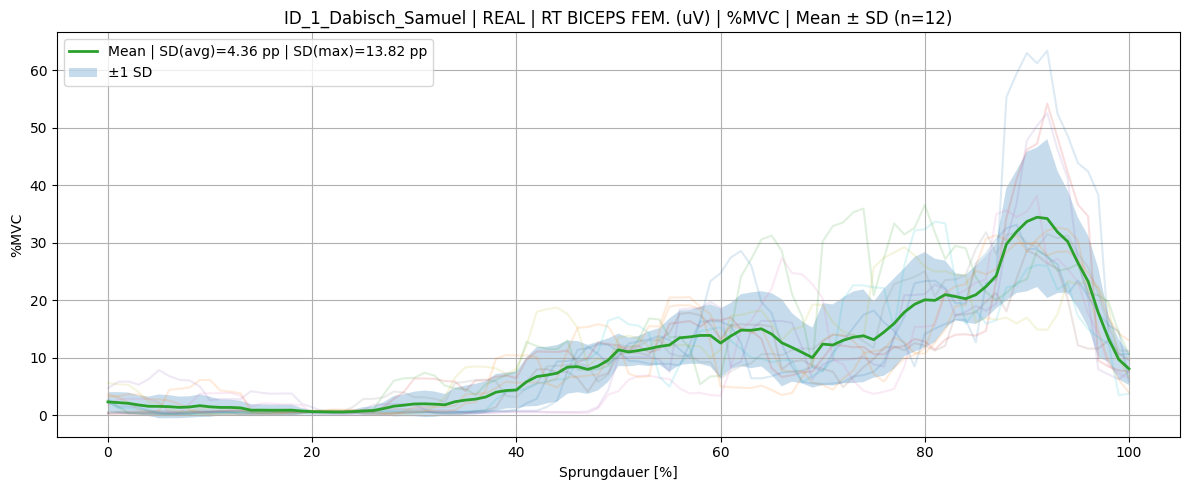

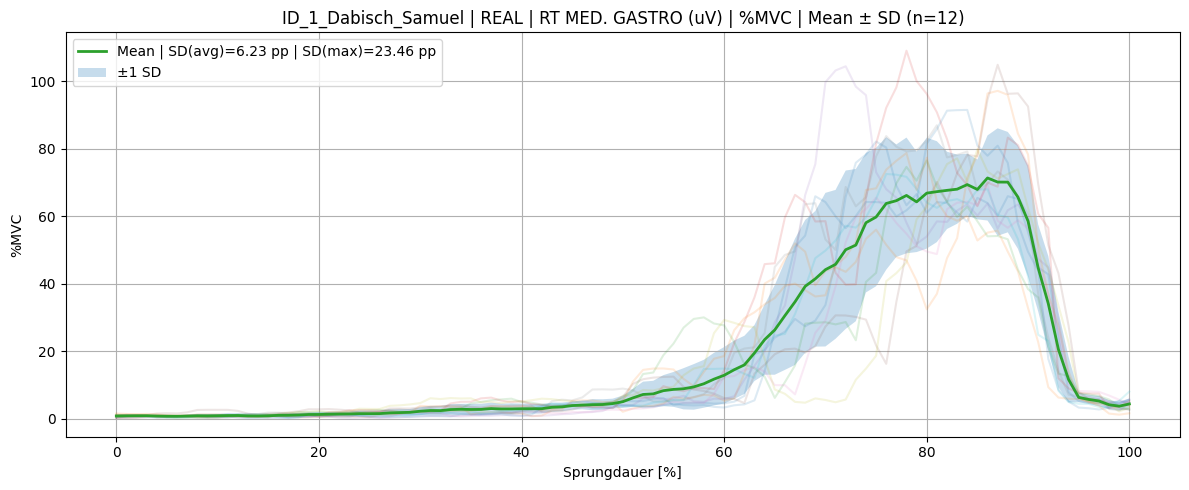

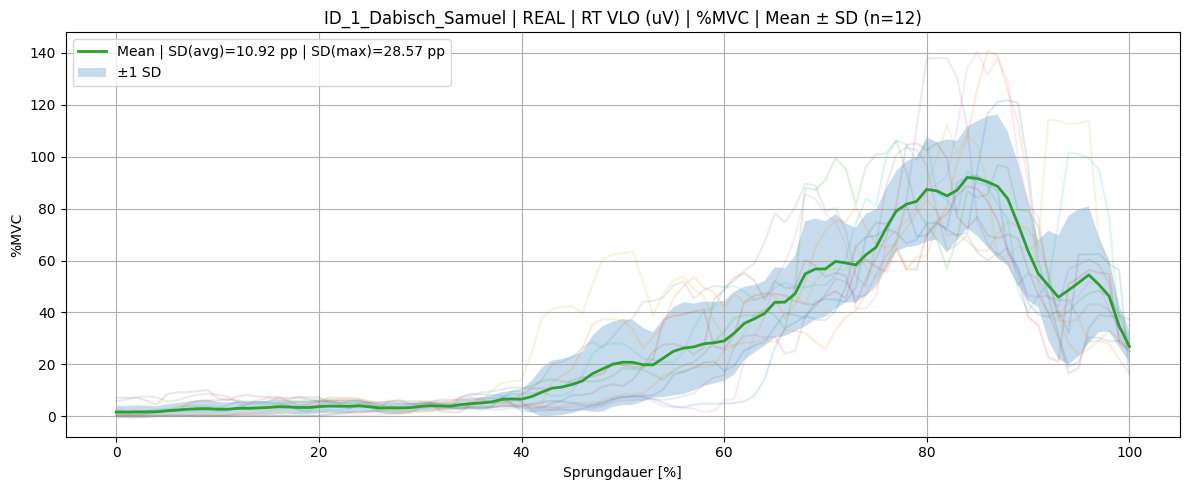

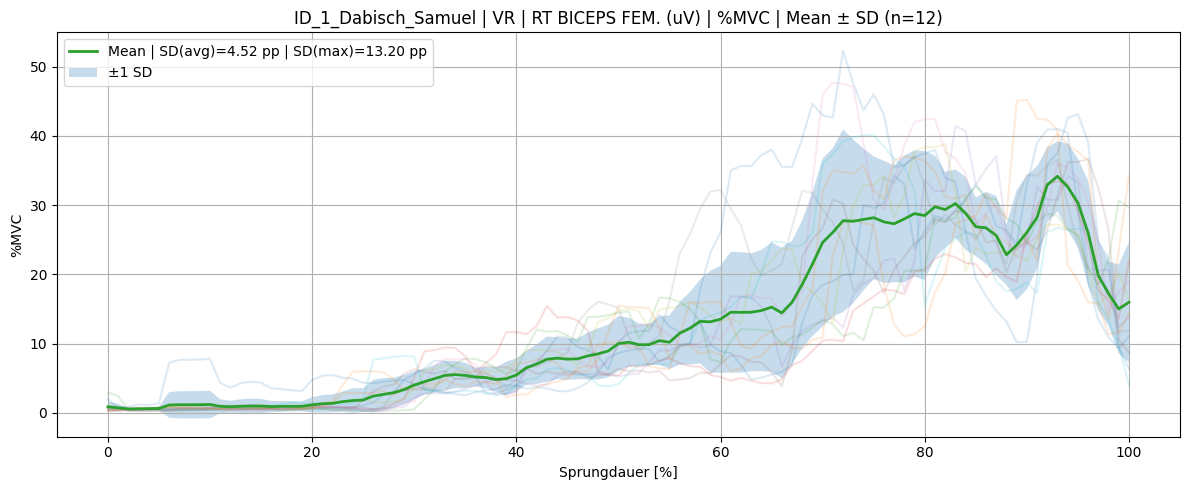

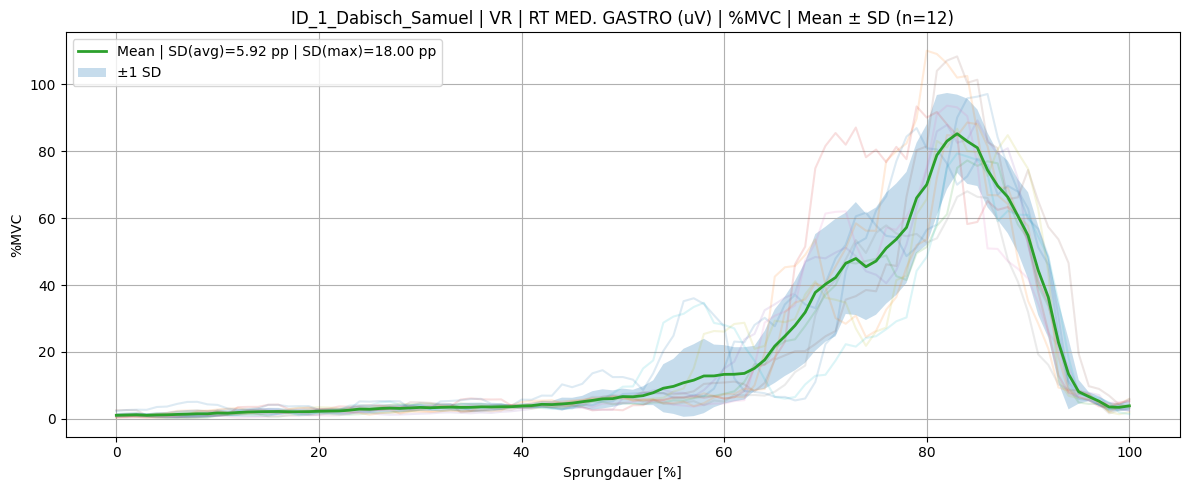

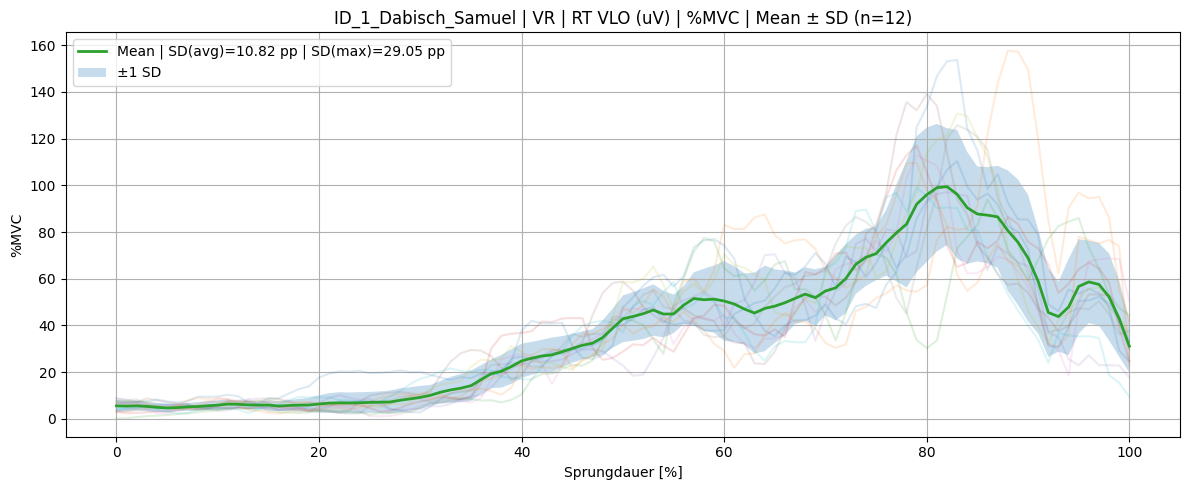

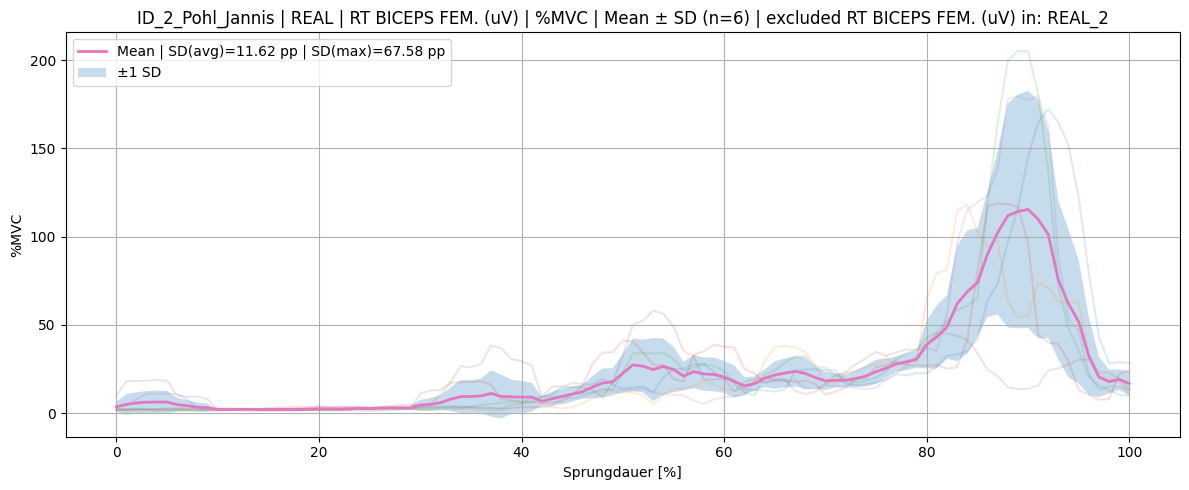

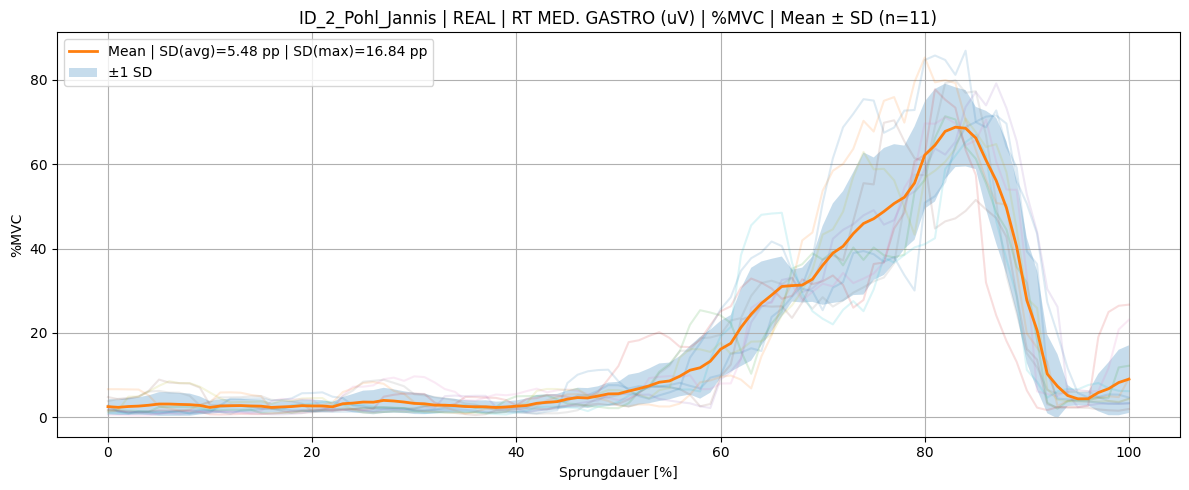

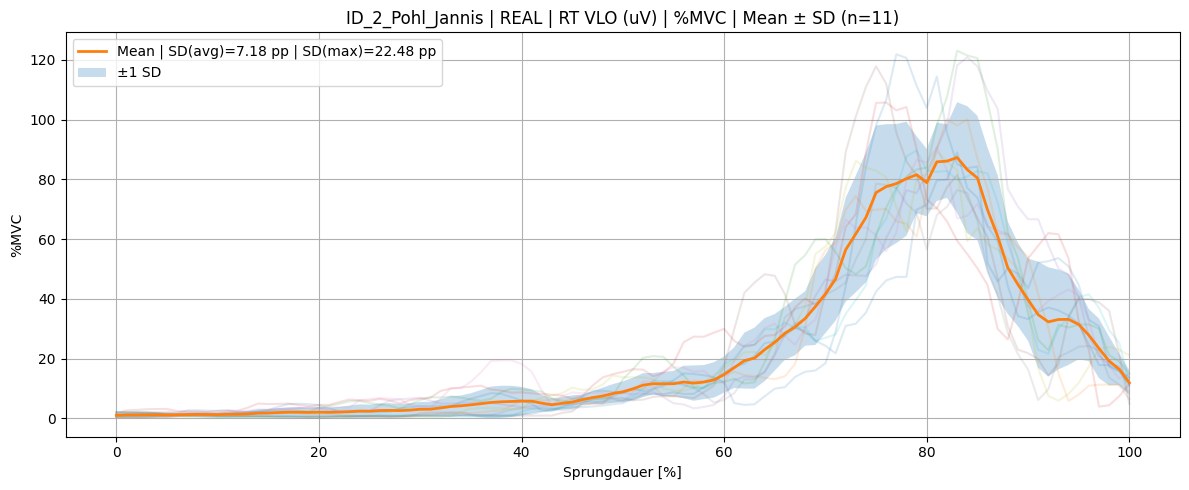

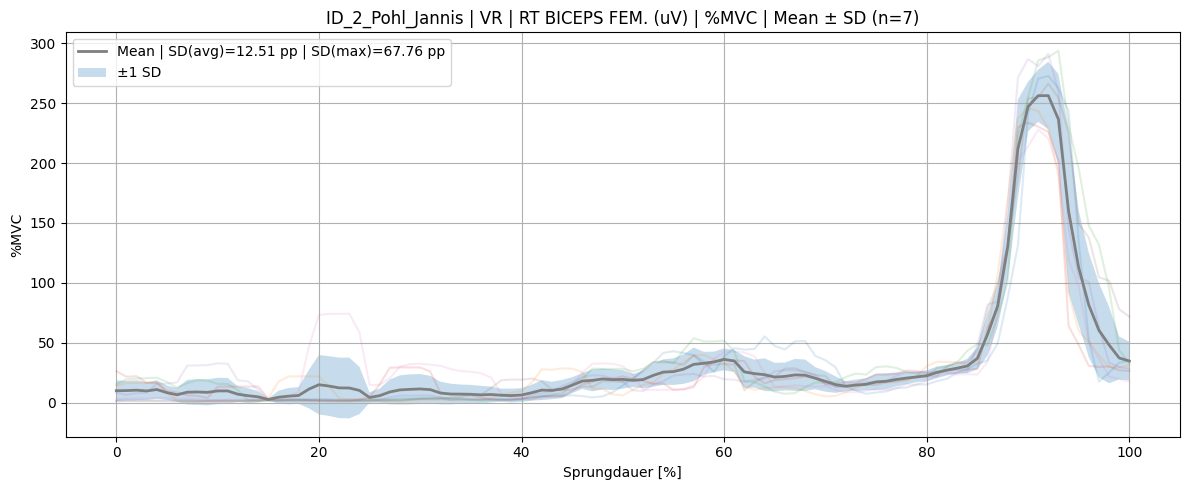

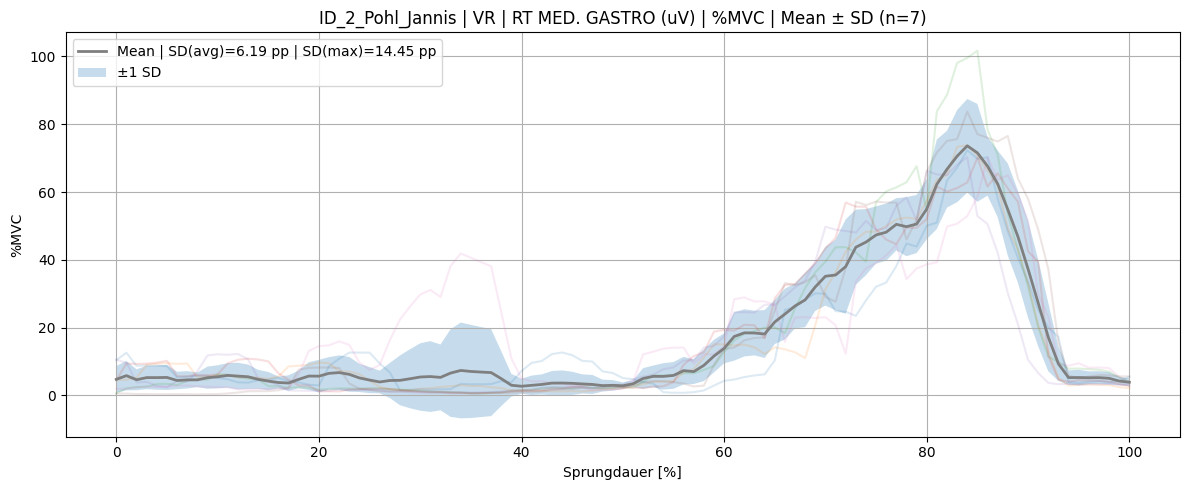

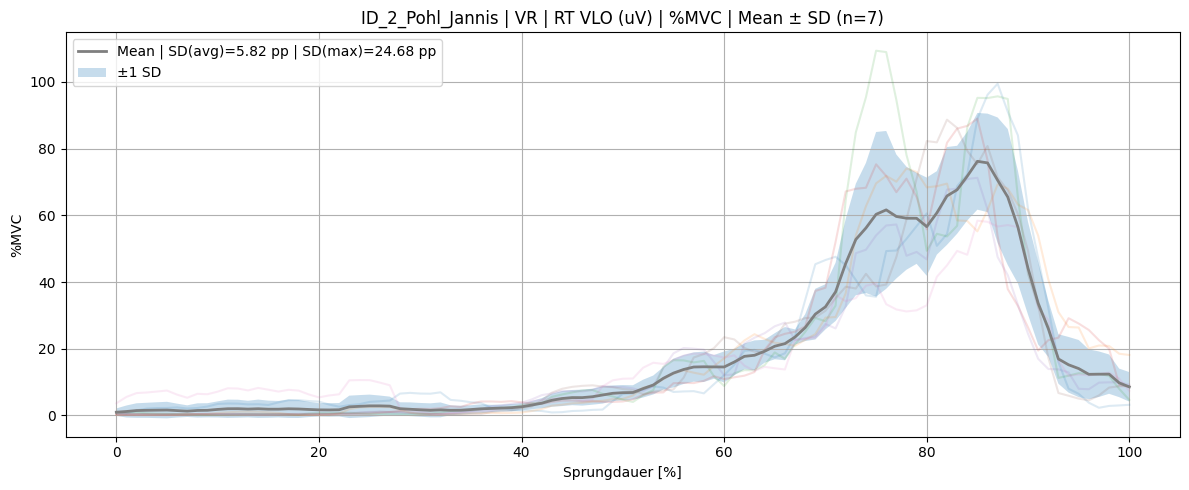

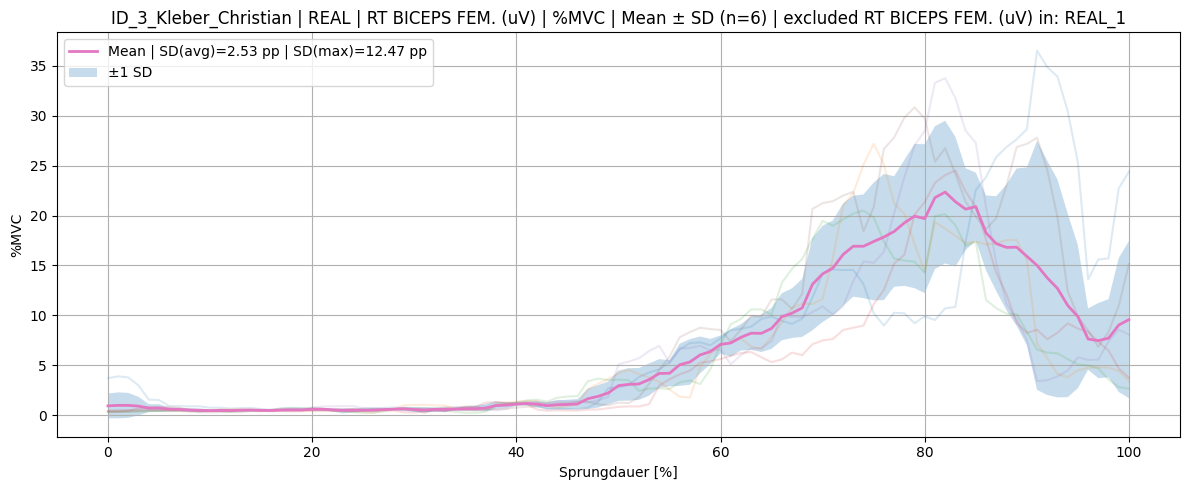

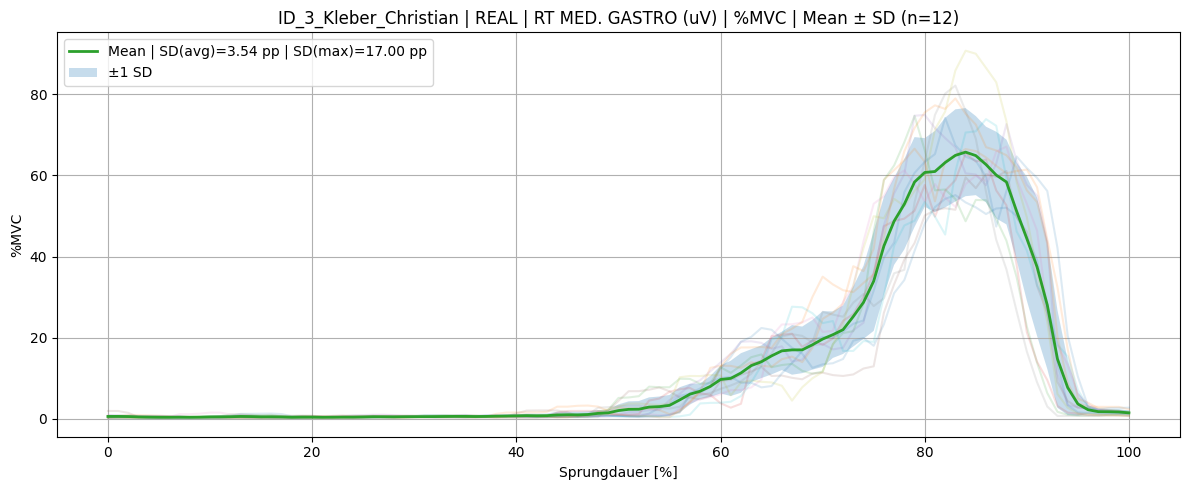

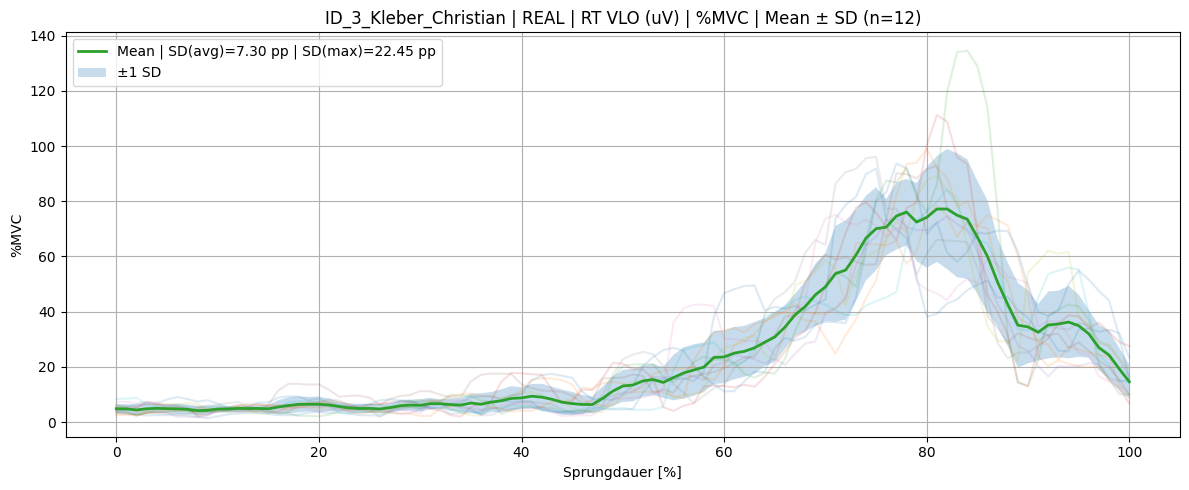

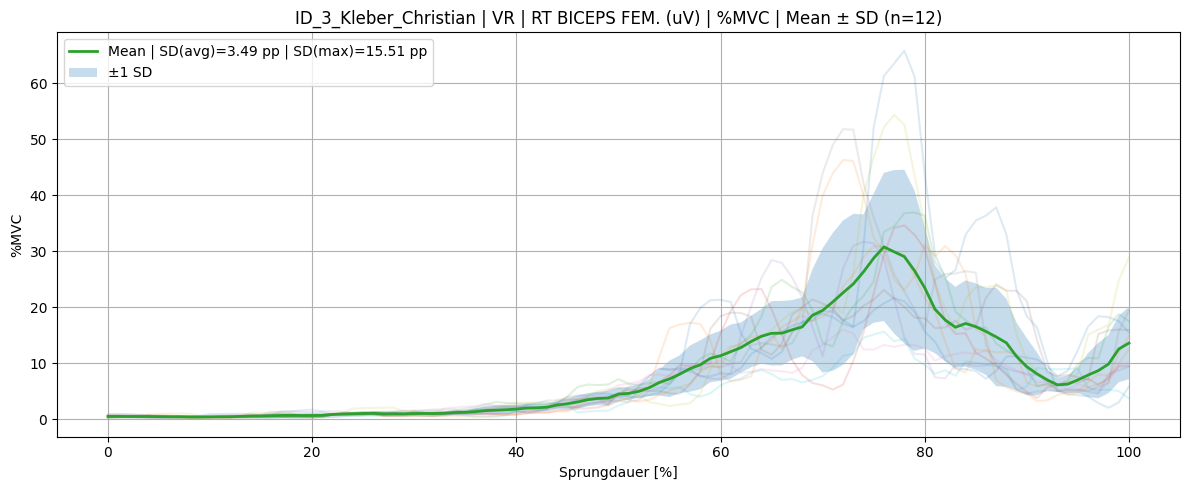

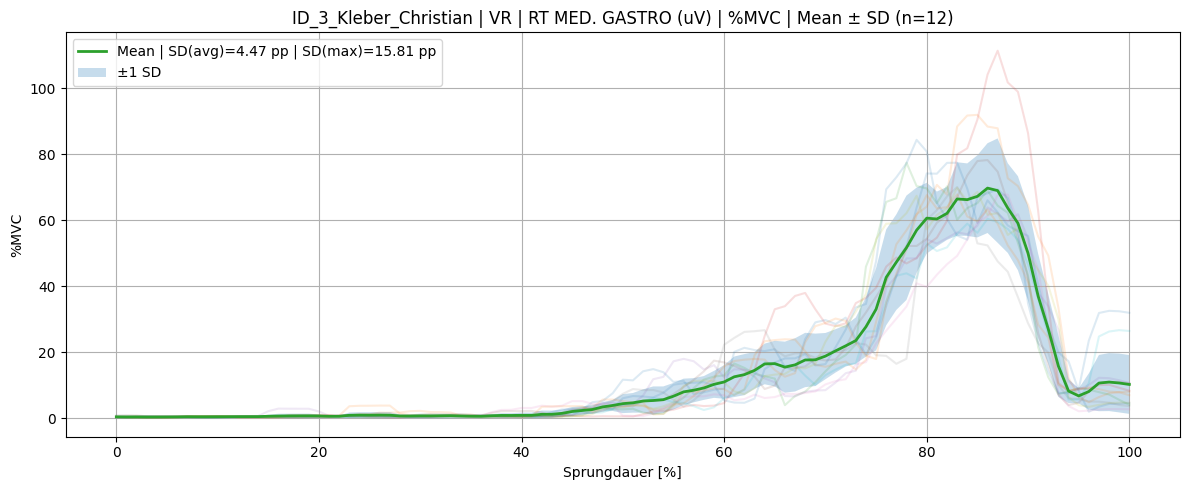

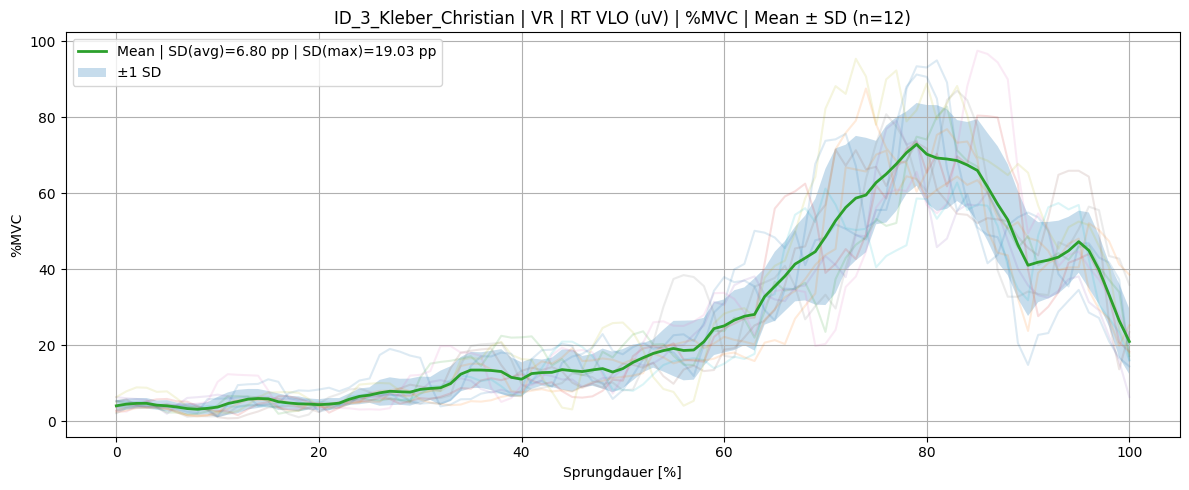

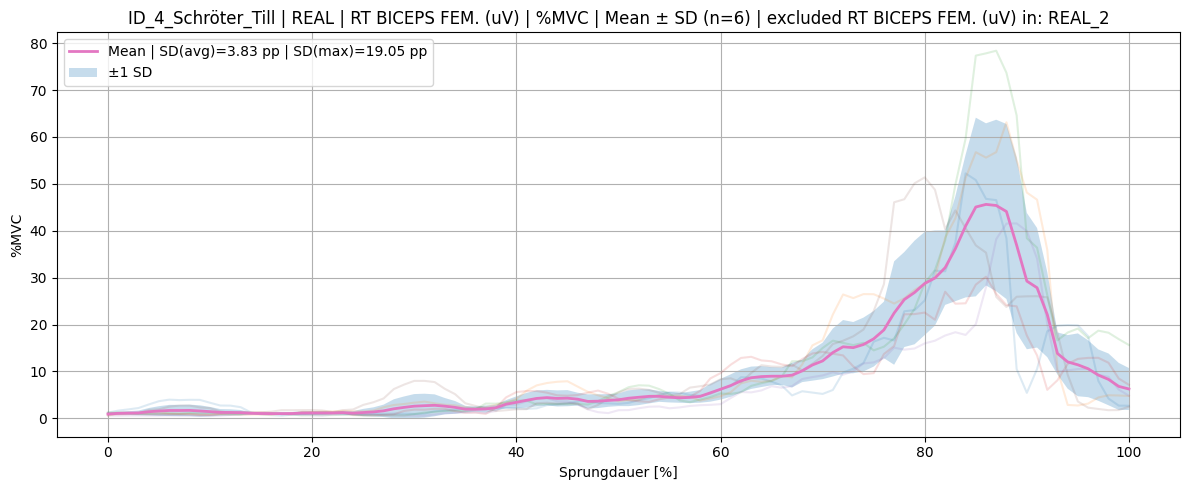

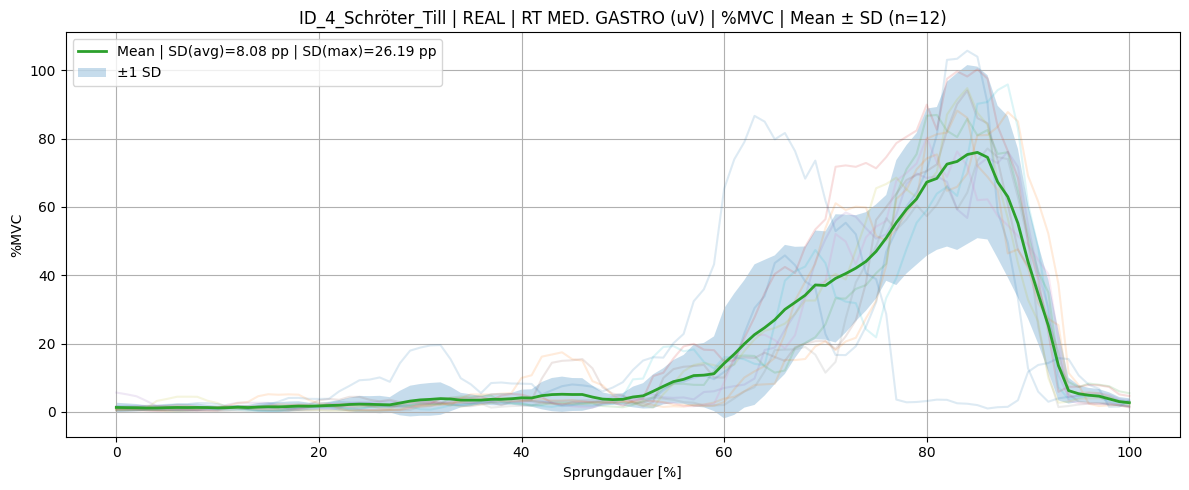

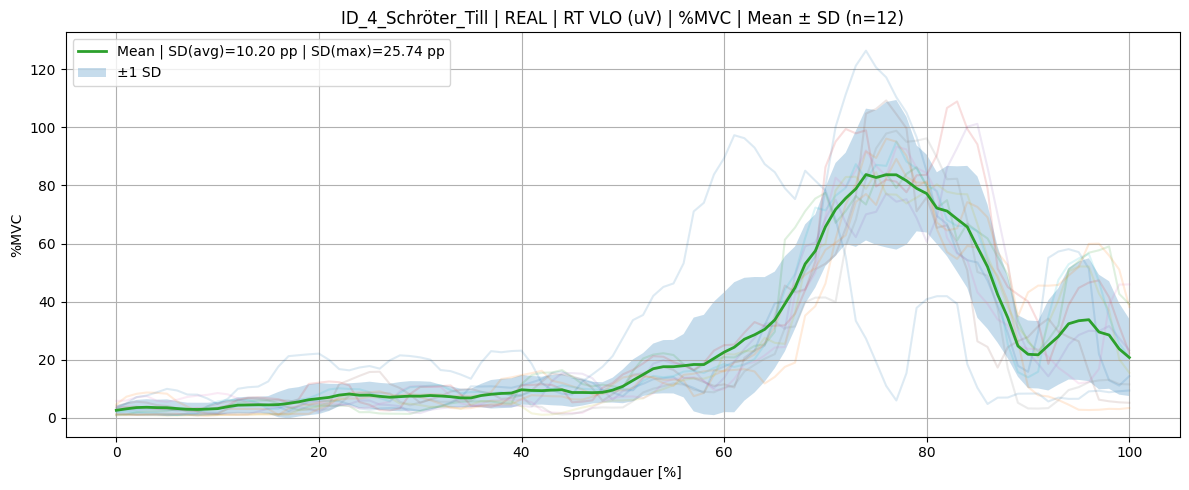

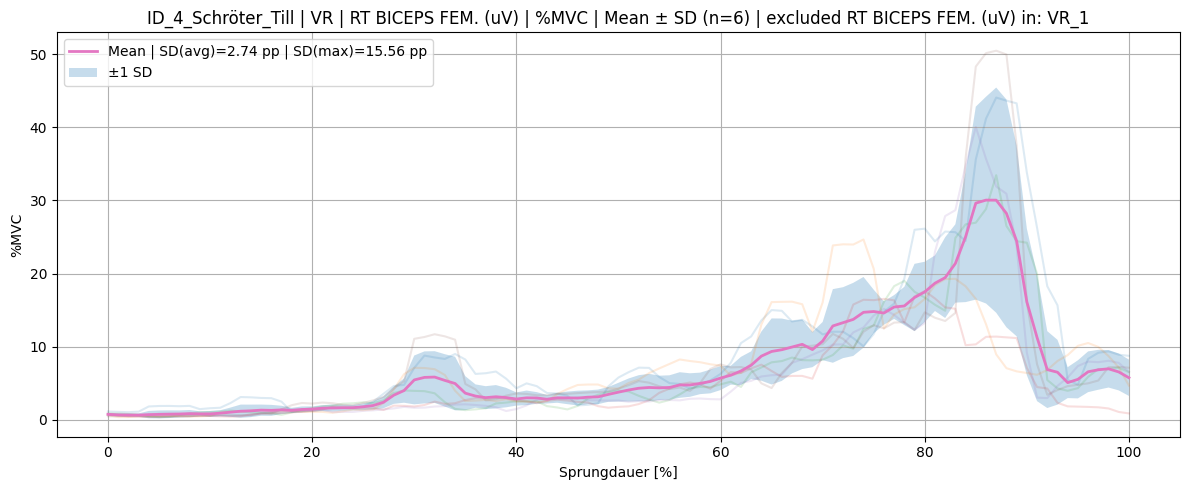

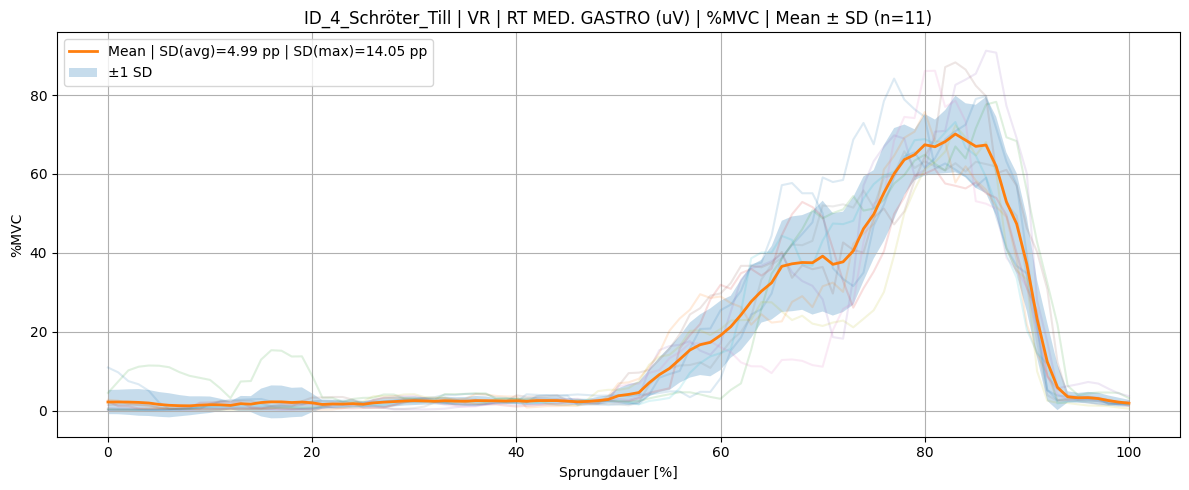

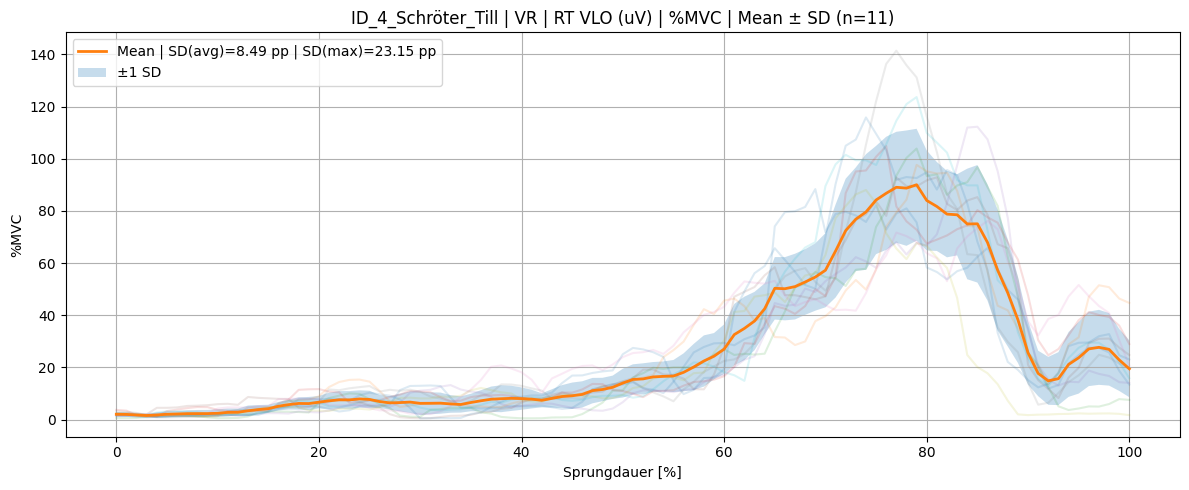

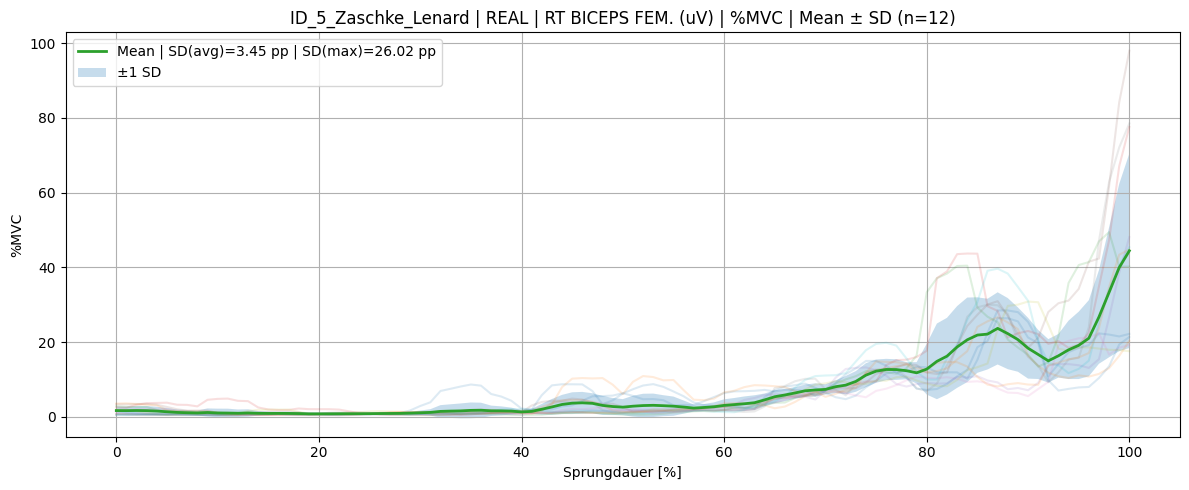

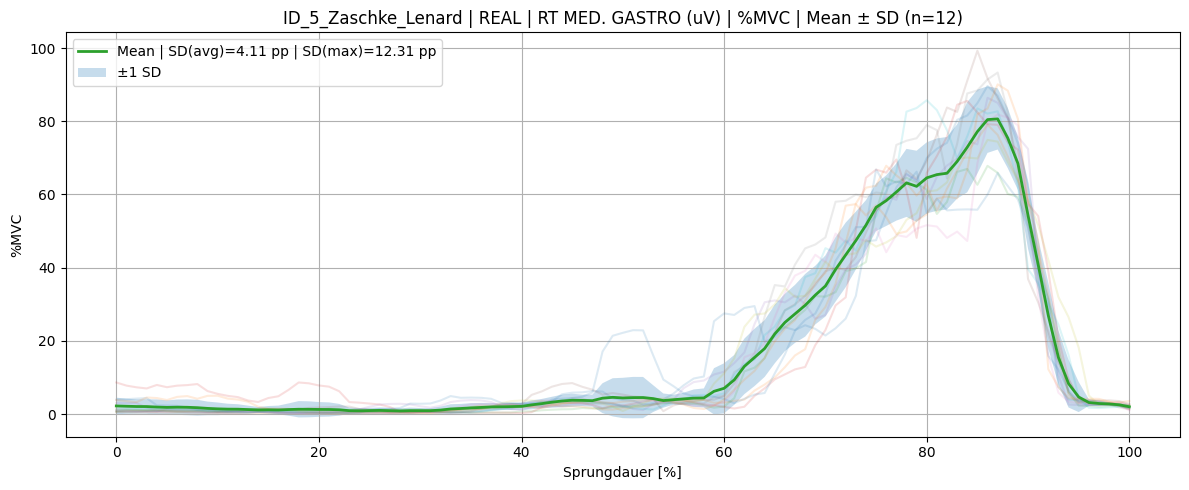

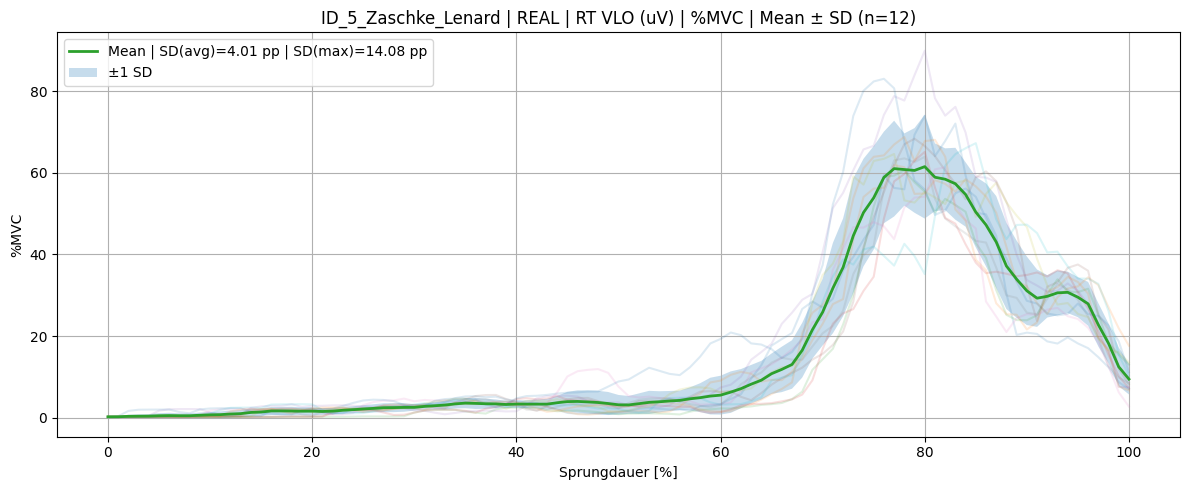

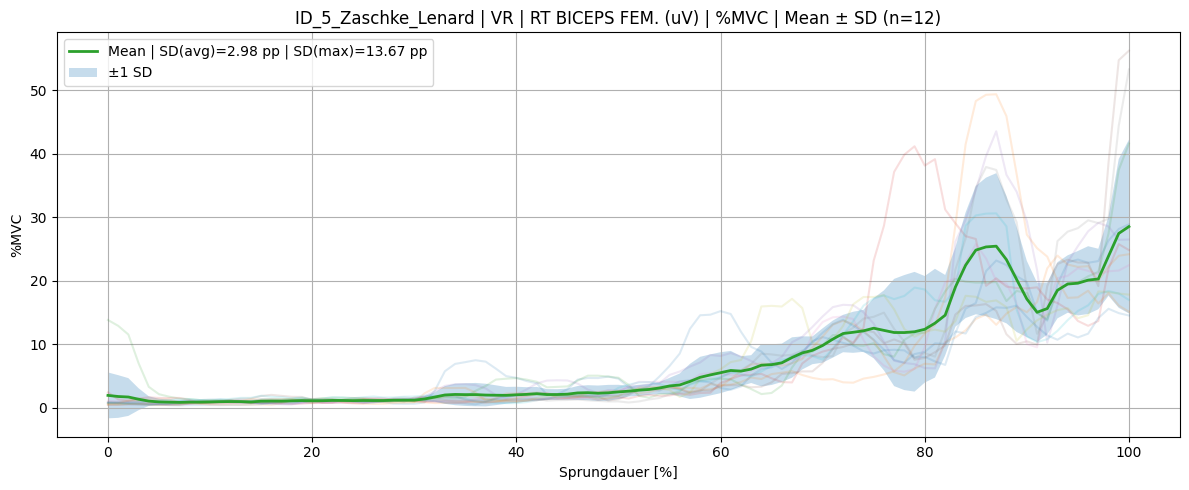

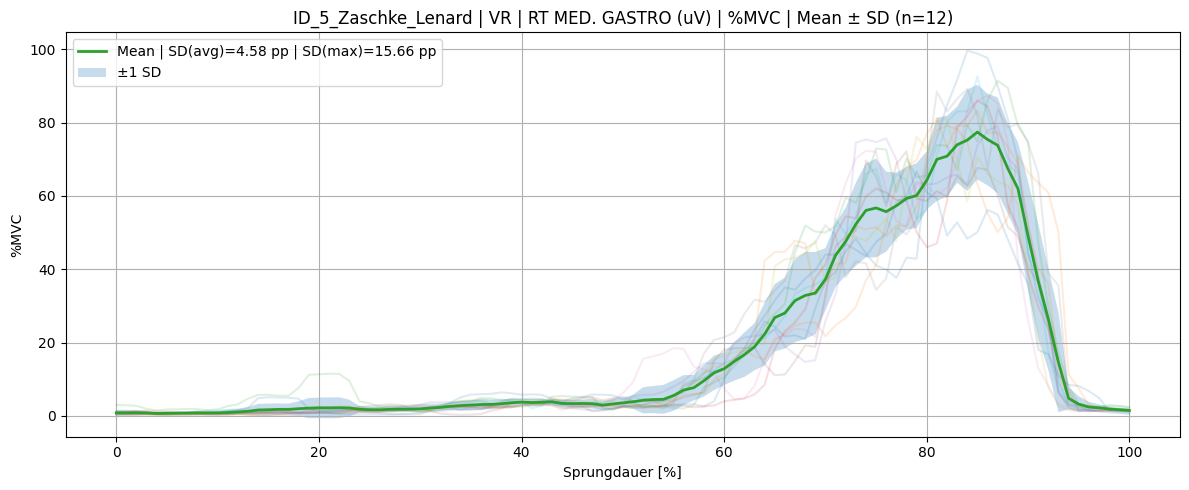

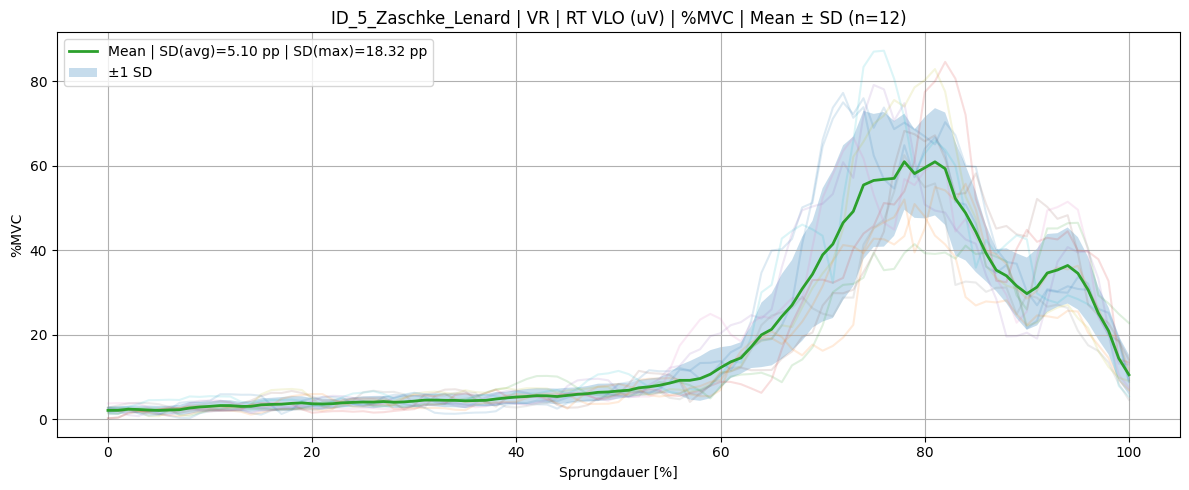

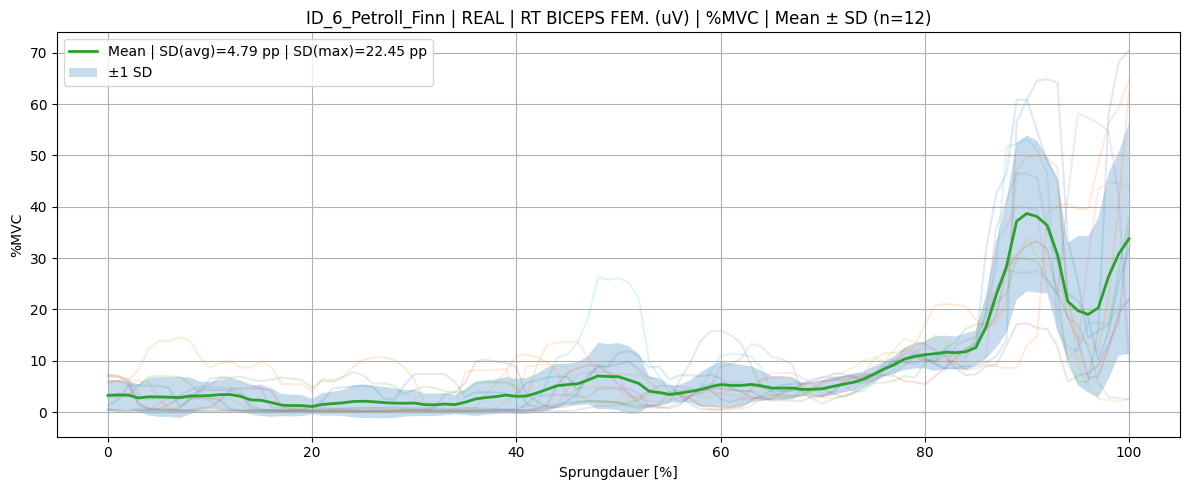

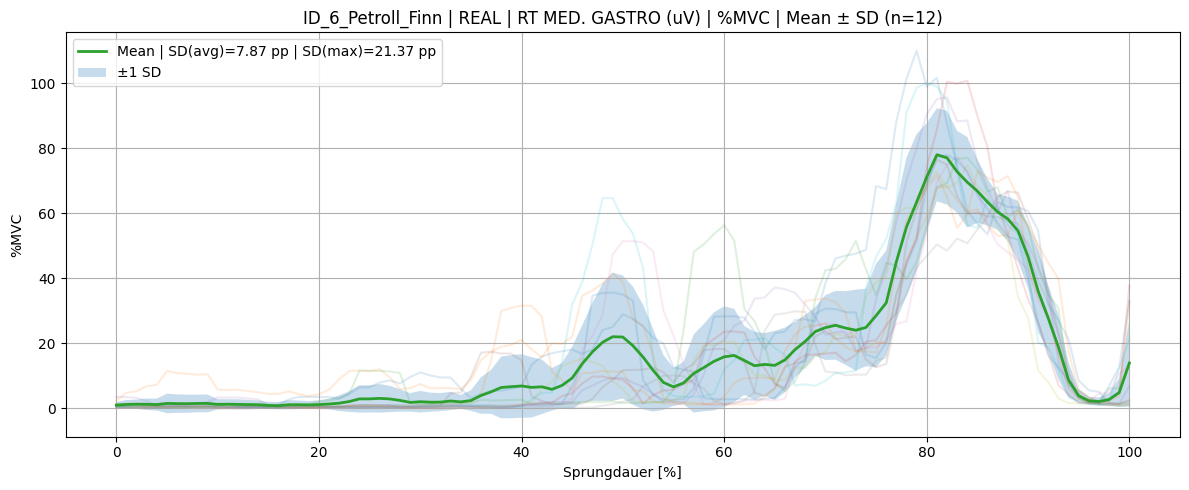

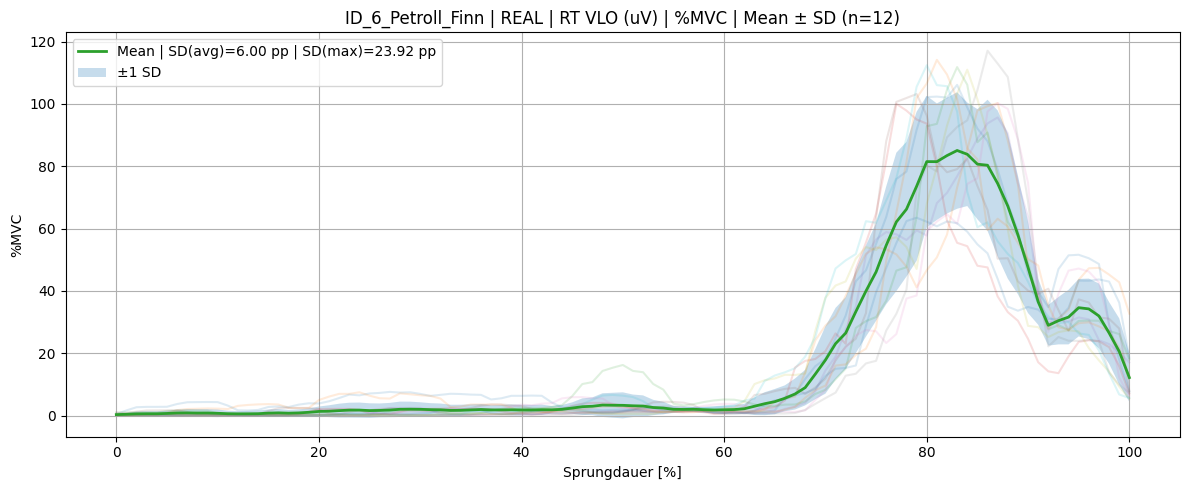

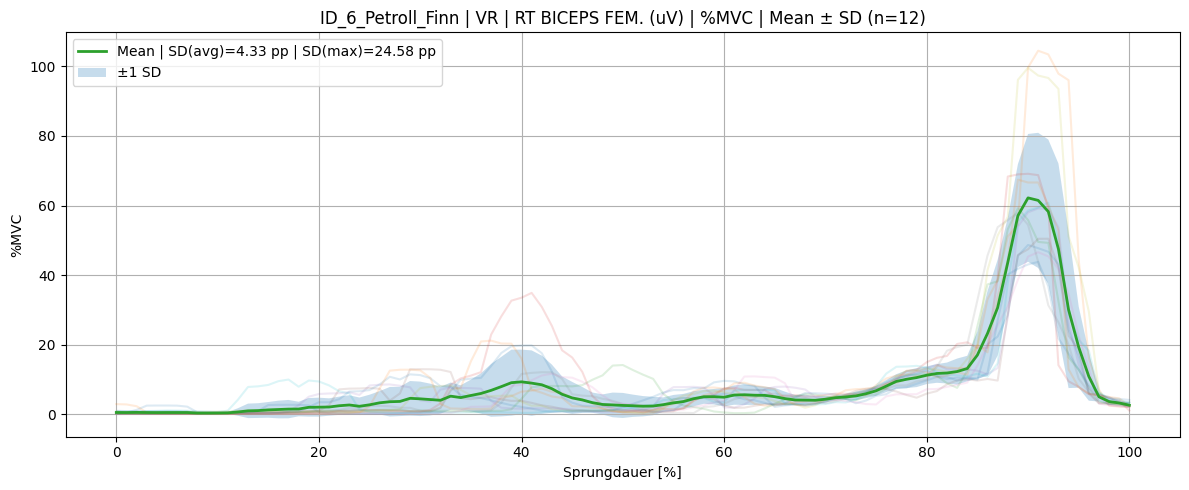

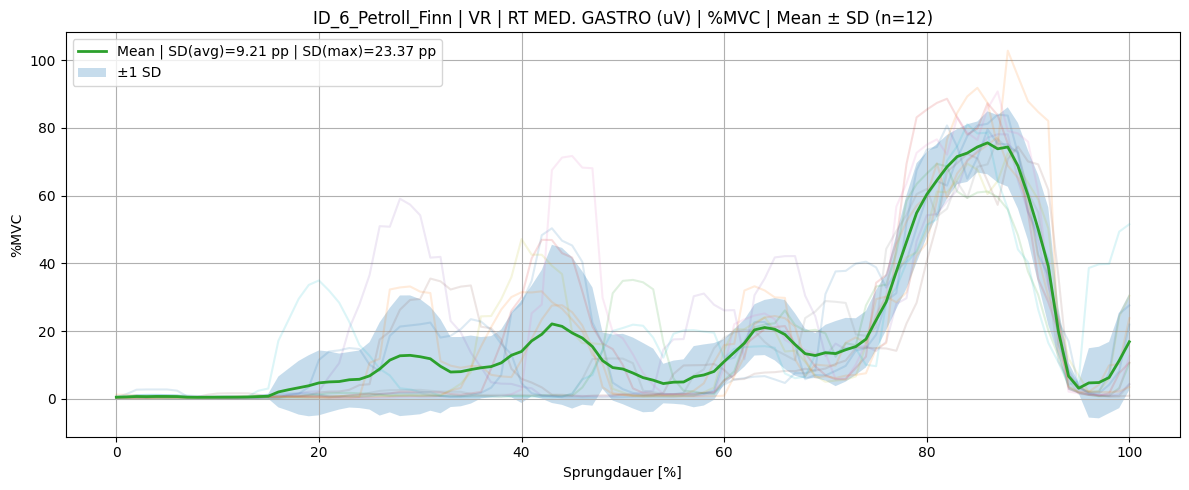

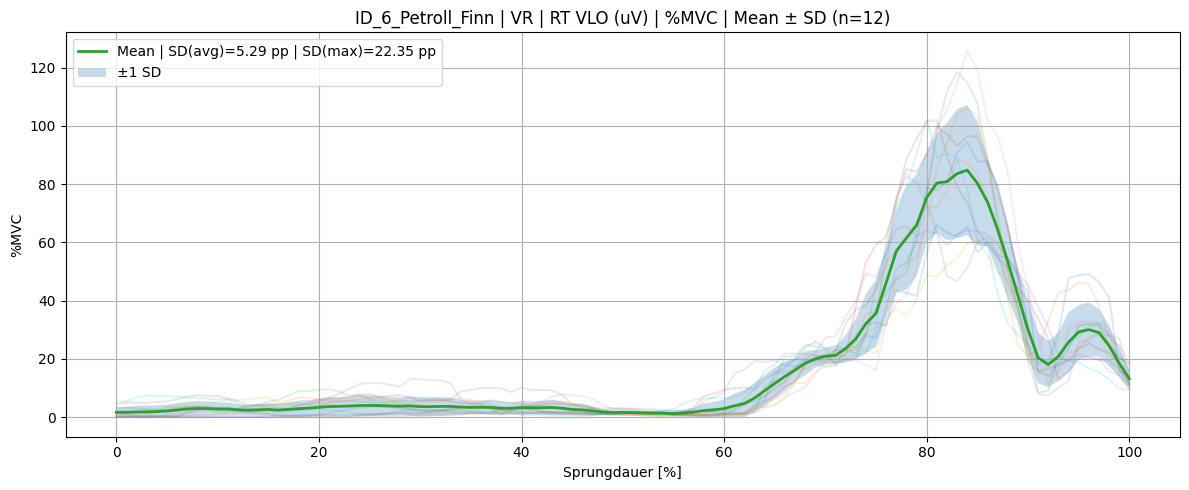

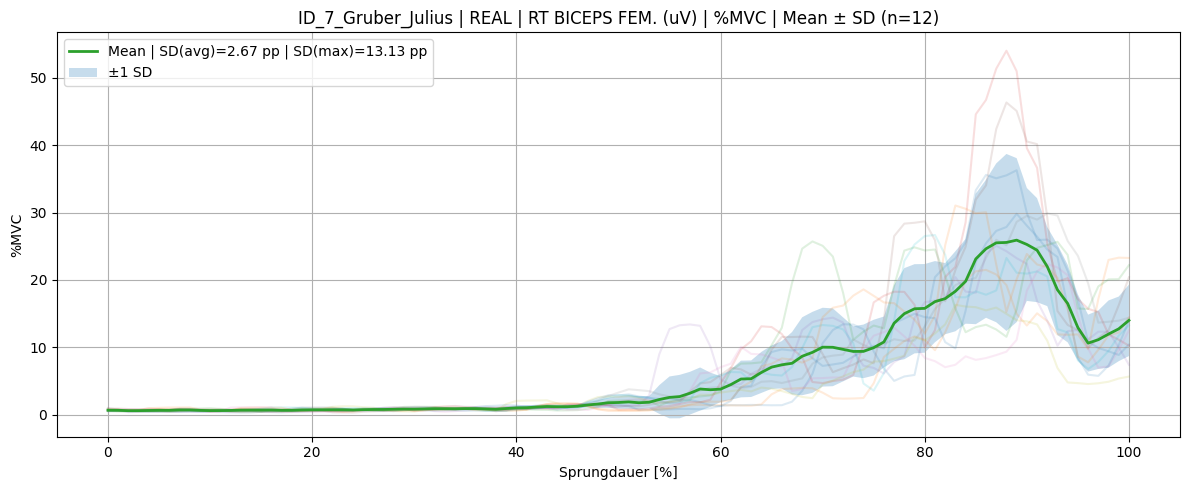

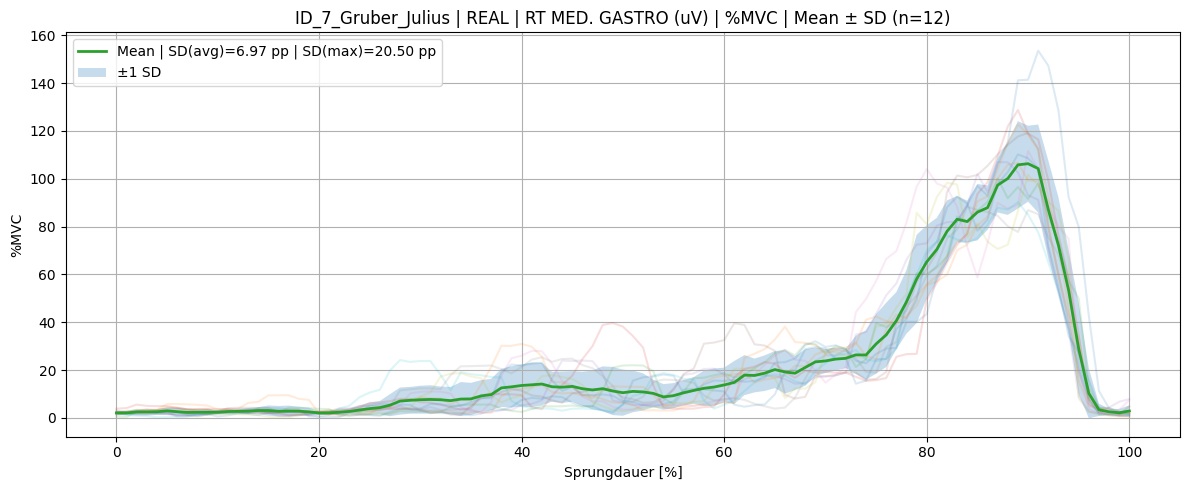

Keine Sprünge für ID_7_Gruber_Julius | REAL | RT VLO (uV)


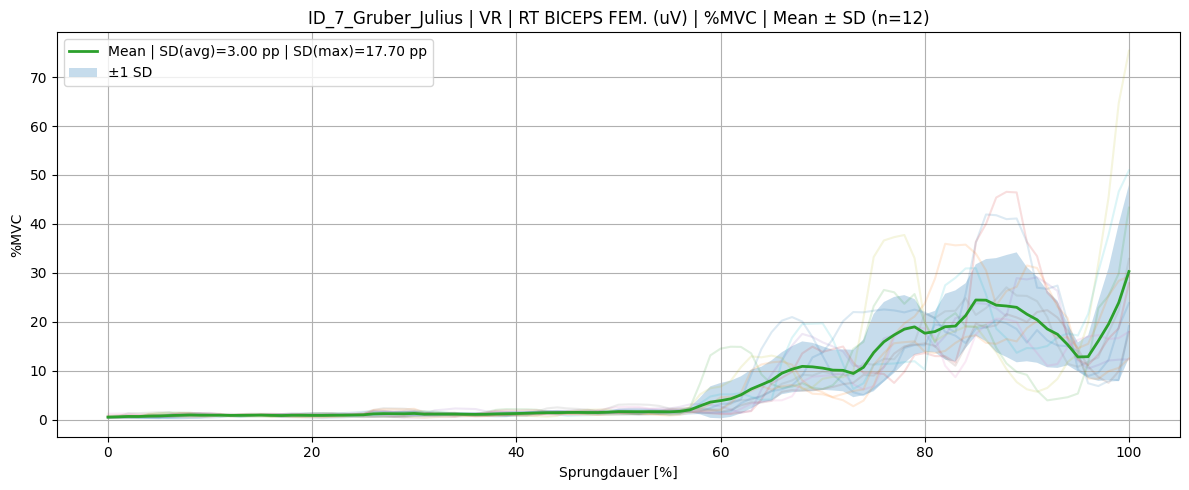

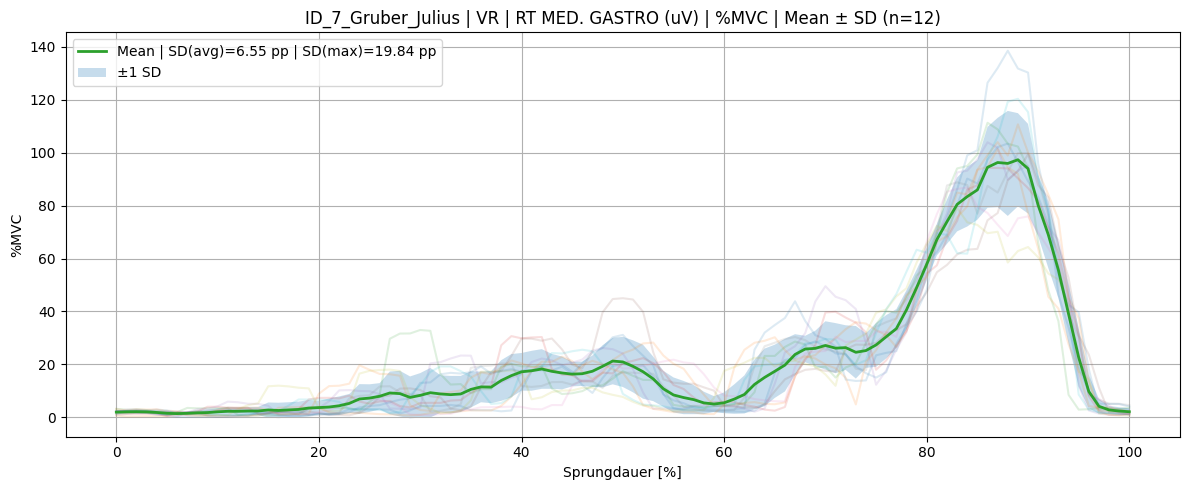

Keine Sprünge für ID_7_Gruber_Julius | VR | RT VLO (uV)


In [12]:
#%% Jump-Timestamps + %MVC Sprünge (0–100%) + Mean±SD + SD-Label + MUSKEL-EXCLUDES ----
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

JUMP_DIR = "jump_analysis_results_knee"

TRIALS_REAL = ["REAL_1", "REAL_2"]
TRIALS_VR   = ["VR_1", "VR_2"]

TIME_COL = "time"
RMS_SUFFIX = "_rms50"
OUT_SUFFIX = "_pctMVC"

# NUR Beine (ohne Tib.Ant.)
LEG_MUSCLES  = ["RT BICEPS FEM. (uV)", "RT MED. GASTRO (uV)", "RT VLO (uV)"]
MUSCLES_TO_PLOT = LEG_MUSCLES

N_POINTS = 101  # 0..100%

# --------- EXCLUDES NUR FÜR EINEN MUSKEL IN EINEM TRIAL (aus deinem Bild) ----------
# Jannis: REAL2 Biceps Fem
# Chris:  REAL1 Biceps Fem
# Till:   REAL2 Biceps Fem + VR1 Biceps Fem
MUSCLE_EXCLUDES = {
    "ID_2_Pohl_Jannis": {
        "REAL_2": ["RT BICEPS FEM. (uV)"],
    },
    "ID_3_Kleber_Christian": {
        "REAL_1": ["RT BICEPS FEM. (uV)"],
    },
    "ID_4_Schröter_Till": {
        "REAL_2": ["RT BICEPS FEM. (uV)"],
        "VR_1":   ["RT BICEPS FEM. (uV)"],
    },
}

def load_jumps_from_folder(participant: str, folder: str) -> pd.DataFrame:
    path = os.path.join(folder, f"{participant}_jumps.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Jump-Datei fehlt: {path}")

    jumps = pd.read_csv(path, sep=None, engine="python")
    jumps.columns = [str(c).strip() for c in jumps.columns]

    required = {"sprung nr.", "start_analyse", "t_absprung", "messung"}
    if not required.issubset(set(jumps.columns)):
        raise ValueError(f"{participant}_jumps.csv hat falsche Spalten. Gefunden: {list(jumps.columns)}")

    jumps["sprung nr."] = pd.to_numeric(jumps["sprung nr."], errors="coerce")
    jumps["start_analyse"] = pd.to_numeric(jumps["start_analyse"], errors="coerce")
    jumps["t_absprung"] = pd.to_numeric(jumps["t_absprung"], errors="coerce")
    jumps["messung"] = jumps["messung"].astype(str).str.strip()

    jumps = jumps.dropna(subset=["sprung nr.", "start_analyse", "t_absprung", "messung"])
    return jumps

def extract_jump_segments(df_trial: pd.DataFrame, jumps_trial: pd.DataFrame, time_col="time"):
    segments = []
    for _, r in jumps_trial.iterrows():
        jn = int(r["sprung nr."])
        t0 = float(r["start_analyse"])
        t1 = float(r["t_absprung"])
        if t1 <= t0:
            continue

        mask = (df_trial[time_col] >= t0) & (df_trial[time_col] <= t1)
        seg = df_trial.loc[mask].copy()
        if len(seg) < 2:
            continue
        seg["sprung nr."] = jn
        segments.append(seg)
    return segments

def resample_to_percent(seg: pd.DataFrame, value_col: str, time_col="time", n_points=101):
    t = seg[time_col].to_numpy(dtype=float)
    y = seg[value_col].to_numpy(dtype=float)

    mask = np.isfinite(t) & np.isfinite(y)
    t = t[mask]; y = y[mask]
    if t.size < 2:
        return None

    t0, t1 = t[0], t[-1]
    if t1 <= t0:
        return None

    tn = (t - t0) / (t1 - t0)
    x_new = np.linspace(0, 1, n_points)
    y_new = np.interp(x_new, tn, y)
    return y_new

def is_muscle_excluded(participant: str, trial: str, muscle_raw: str) -> bool:
    return muscle_raw in MUSCLE_EXCLUDES.get(participant, {}).get(trial, [])

def plot_mean_sd_pctmvc_for_participant(participant: str, all_data, jumps_df: pd.DataFrame,
                                        muscles_raw, trials_group, group_name="REAL",
                                        time_col="time", n_points=101):
    x = np.linspace(0, 100, n_points)

    for muscle_raw in muscles_raw:
        col = muscle_raw + RMS_SUFFIX + OUT_SUFFIX

        curves = []
        used_trials = []
        excluded_trials_for_this_muscle = []

        for trial in trials_group:
            if is_muscle_excluded(participant, trial, muscle_raw):
                excluded_trials_for_this_muscle.append(trial)
                continue  # <-- nur dieser Muskel in diesem Trial wird übersprungen

            df_trial = all_data[participant].get(trial, None)
            if df_trial is None:
                continue
            if col not in df_trial.columns:
                continue

            jumps_trial = jumps_df[jumps_df["messung"] == trial]
            if jumps_trial.empty:
                continue

            segments = extract_jump_segments(df_trial, jumps_trial, time_col=time_col)

            for seg in segments:
                y_new = resample_to_percent(seg, col, time_col=time_col, n_points=n_points)
                if y_new is not None:
                    curves.append(y_new)
                    used_trials.append(trial)

        if len(curves) == 0:
            print(f"Keine Sprünge für {participant} | {group_name} | {muscle_raw}")
            continue

        Y = np.vstack(curves)
        mean = np.nanmean(Y, axis=0)
        sd   = np.nanstd(Y, axis=0)

        sd_mean_pp = float(np.nanmean(sd))
        sd_max_pp  = float(np.nanmax(sd))

        plt.figure(figsize=(12, 5))

        for y in Y:
            plt.plot(x, y, alpha=0.15)

        plt.plot(x, mean, linewidth=2,
                 label=f"Mean | SD(avg)={sd_mean_pp:.2f} pp | SD(max)={sd_max_pp:.2f} pp")
        plt.fill_between(x, mean - sd, mean + sd, alpha=0.25, label="±1 SD")

        excl_txt = ""
        if excluded_trials_for_this_muscle:
            excl_txt = f" | excluded {muscle_raw} in: {', '.join(sorted(set(excluded_trials_for_this_muscle)))}"

        plt.title(f"{participant} | {group_name} | {muscle_raw} | %MVC | Mean ± SD (n={Y.shape[0]}){excl_txt}")
        plt.xlabel("Sprungdauer [%]")
        plt.ylabel("%MVC")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# --------- Ausführen für alle Participants ----------
for participant in participants:
    jumps_df = load_jumps_from_folder(participant, JUMP_DIR)

    plot_mean_sd_pctmvc_for_participant(
        participant, all_data, jumps_df,
        muscles_raw=MUSCLES_TO_PLOT,
        trials_group=TRIALS_REAL,
        group_name="REAL",
        time_col=TIME_COL,
        n_points=N_POINTS
    )

    plot_mean_sd_pctmvc_for_participant(
        participant, all_data, jumps_df,
        muscles_raw=MUSCLES_TO_PLOT,
        trials_group=TRIALS_VR,
        group_name="VR",
        time_col=TIME_COL,
        n_points=N_POINTS
    )